# Measuring Engagement and Satisfaction in Online Mental Health Platform Conversations

## Data preprocessing

In [89]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from math import log10, floor
import math
import nltk
import string
from nltk.tokenize import sent_tokenize
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()

pd.set_option('mode.chained_assignment',None)

In [41]:
# Display long column text
pd.options.display.max_colwidth = 500

df = pd.read_csv("mentalhealthsupport_dyadic_convs_clean_emotion.csv")
df = df.rename(columns={'conversation id': 'conversation_id', 'post title': 'post_title', 'dialog turn': 'dialog_turn', 'emotion prediction': 'emotion_prediction'})

In [42]:
### --- CLEANING OUT CONVERSATIONS WITH ONLY 1 OR 2 TURN(S) AND/OR WITH A SINGLE AUTHOR --- ###

# Group data by conversation id and calculate count of each conversation id
df_conv_len = df.groupby("conversation_id").count()
df_conv_len = df_conv_len.drop(columns=["subreddit", "post_title", "author", "text", "compound", "sentiment", "emotion_prediction"])
print("Number of conversations in subreddit: ", len(df_conv_len))

# Separate conversation id's with a single occurrence as monologues
df_mono = df_conv_len[df_conv_len["dialog_turn"] == 1]
#print("Number of conversations with a single turn in subreddit: ", len(df_mono))
df_mono_ids = df_mono.reset_index()
df_mono_ids = df_mono_ids["conversation_id"]

# Separate conversation id's with multiple occurrences as dialogues
df_dia = df_conv_len[df_conv_len["dialog_turn"] > 2]
print("Number of conversations longer than 2 turns in subreddit: ", len(df_dia))
df_dia = df_dia.reset_index()
df_dia = df_dia.drop(columns=['dialog_turn'])

# Join dialogue conversation id's with original data such that only dialogues remain in the dataset
df = df.join(df_dia.set_index('conversation_id'), on='conversation_id', how="right") 

# Separate conversations that have more than one author
df_conv_authors = df.groupby("conversation_id")["author"].unique().reset_index()
df_conv_authors["author"] = df_conv_authors["author"].apply(lambda x: x.size)
df_conv_authors = df_conv_authors[df_conv_authors["author"] > 1]
df_conv_authors = df_conv_authors.drop(columns=['author'])

# Join dialogue conversation id's with original data such that only conversations that have more than one author remain in the dataset
df = df.join(df_conv_authors.set_index('conversation_id'), on='conversation_id', how="right") 
print("Number of conversations longer than 2 turns with more than a single author in subreddit: ", len(df_conv_authors))

### ---------------------------------------------- ###

Number of conversations in subreddit:  3551
Number of conversations longer than 2 turns in subreddit:  487
Number of conversations longer than 2 turns with more than a single author in subreddit:  476


In [43]:
# Round numbers to a given number of significant figures (default = 2)
def round_sig(x, sig=2):
    if x != 0:
        return round(x, sig-int(floor(log10(abs(x))))-1)
    else:
        return

## Extracting conversation, speaker, and listener

In [44]:
def extract_responses(conversation_id):
    conversation = df[df["conversation_id"] == conversation_id]
    conversation.reset_index(drop=True, inplace=True)
    speaker = conversation.author.iloc[0]
    listener = conversation[conversation["author"] != speaker]["author"].unique().item() 
    speaker_responses = conversation[conversation["author"] == speaker]
    listener_responses = conversation[conversation["author"] == listener]
    num_speaker_responses = len(speaker_responses) 
    num_listener_responses = len(listener_responses)
    # TOIMPROVE: you can only keep conversation, speaker, and listener (because others are dynamic and can be calculated from these 3)
    return conversation, speaker, listener, speaker_responses, listener_responses, num_speaker_responses, num_listener_responses

## Measuring the level of engagement

In [45]:
# Calculates token length for all speaker responses except for the first and adds it to a new column 'token_length', and returns their sum.
def calculate_speaker_token_length(conversation, speaker):
    # Create an empty dataframe column 'token_length'
    conversation.loc[:,'token_length'] = np.nan
    
    sum_token_length = 0
    
    for i in range(1, len(conversation)):
        if conversation['author'].iloc[i] == speaker:
            # Tokenize speaker response and filter punctuations
            tokens = nltk.word_tokenize(conversation["text"][i])
            tokens = list(filter(lambda tokens: tokens not in string.punctuation, tokens)) # TOIMPROVE: exclude quotation marks
            
            # Add token length to dataframe
            conversation.at[i,'token_length'] = len(tokens)
            
            # Calculate sum of all tokens by speaker
            sum_token_length += len(tokens)
        
    return conversation, sum_token_length

In [46]:
def merge_consecutive_speaker_responses(conversation, speaker, listener):
    i = 0
    
    while i < (len(conversation) - 1):
        if conversation['author'].iloc[i] == speaker and conversation['author'].iloc[i+1] == speaker:
            if (conversation['dialog_turn'].iloc[i] + 1) == conversation['dialog_turn'].iloc[i+1]:
                dropped_turn = conversation['dialog_turn'].iloc[i+1]
                former_text = conversation['text'][i]
                latter_text = conversation['text'][i+1]

                # Merge consecutive responses of the speaker
                merged_text = former_text + " " + latter_text 
                conversation['text'].replace({former_text: merged_text}, inplace=True)

                # Get names of indexes for which column dialog_turn has value of the dropped turn
                conversation_index_names = conversation[conversation['dialog_turn'] == dropped_turn].index

                # Delete these row indexes from dataframe
                conversation.drop(conversation_index_names, inplace=True)

                # Reset indexes
                conversation.reset_index(drop=True, inplace=True)
                
                # TODO: Run the sentiment and emotion analysis code and retag the merged texts
                # I assume VADER
                
        i += 1
        
    speaker_responses = conversation[conversation["author"] == speaker]
    listener_responses = conversation[conversation["author"] == listener]
    num_speaker_responses = len(speaker_responses) 
    num_listener_responses = len(listener_responses)
                 
    return conversation, num_speaker_responses, num_listener_responses

In [47]:
# If all the even-numbered turns are by the speaker and if all the odd-numbered turns are by the listener, returns True. Otherwise, returns False.
def is_interleaved_conversation(speaker, listener, conversation):
    num_turns = len(conversation)
    
    for i in range(0, num_turns, 2):
        if conversation['author'].iloc[i] == speaker:
            continue
        else:
            return False
        
    for i in range(1, num_turns, 2):
        if conversation['author'].iloc[i] == listener:
            continue
        else:
            return False
        
    return True

In [274]:
# Obtain sentence-level sentiment compounds
def sent_lvl_sentiment(conversation):
    conversation, speaker, listener, speaker_responses, listener_responses, num_speaker_responses, num_listener_responses = extract_responses(24)
    conversation['sentences'] = conversation['text'].apply(lambda x: sent_tokenize(x)) # optionally, I could directly replace text with tokenized version

    conversation['sentence_compounds'] = conversation['sentences']
    for i in range(0,len(conversation)):

        num_sentences = len(sent_tokenize(conversation['text'].iloc[i]))
        scores = np.zeros(num_sentences)

        for j in range(0,num_sentences):
            # i'th turn, j'th sentence
            scores[j] = sid.polarity_scores(sent_tokenize(conversation['text'][i])[j])['compound']

            conversation['sentence_compounds'][i] = scores
            
    return conversation

In [172]:
sentences = "Thank you for the response. I'm going to try that tonight. Hopefully it will work, I'll get back to you!"
len(sent_tokenize(sentences))

3

In [237]:
sentences = "Thank you for the response. I'm going to try that tonight. Hopefully it will work, I'll get back to you!"


In [188]:

for i in range(0,len(sent_tokenize(sentences))):
    scores[i] = sid.polarity_scores(sent_tokenize(sentences)[i])['compound']
print(scores)

[0.3612 0.     0.4574]


In [256]:
conversation['text'].iloc[0]

'How they knew ill never know... But SOMEONE told them that shouldnt have... Here goes... I was on my way home after an evaluation ( dont worry everyone,  still nutty) and i stop by the grocery store to pick up a few things. . and the cashier says, " we pay for that, dont we?" in relation to my purchase. How in the hell did a cashier know i was on disability? Giving me a reason, without an identifiable motive is a good way to get yourself hurt. Keep it up.'

In [262]:
sent_tokenize(conversation['text'][0])[0]

'How they knew ill never know...'

In [254]:
sent_tokenize(sentences)

['How they knew ill never know...',
 'But SOMEONE told them that shouldnt have...',
 'Here goes...',
 'I was on my way home after an evaluation ( dont worry everyone,  still nutty) and i stop by the grocery store to pick up a few things.',
 '.',
 'and the cashier says, " we pay for that, dont we?"',
 'in relation to my purchase.',
 'How in the hell did a cashier know i was on disability?',
 'Giving me a reason, without an identifiable motive is a good way to get yourself hurt.',
 'Keep it up.']

In [238]:
len(sent_tokenize(sentences))

3

In [266]:
sent_tokenize(conversation['text'].iloc[0])

['How they knew ill never know...',
 'But SOMEONE told them that shouldnt have...',
 'Here goes...',
 'I was on my way home after an evaluation ( dont worry everyone,  still nutty) and i stop by the grocery store to pick up a few things.',
 '.',
 'and the cashier says, " we pay for that, dont we?"',
 'in relation to my purchase.',
 'How in the hell did a cashier know i was on disability?',
 'Giving me a reason, without an identifiable motive is a good way to get yourself hurt.',
 'Keep it up.']

In [268]:
sid.polarity_scores('But SOMEONE told them that shouldnt have...')['compound']

0.0

,conversation_id,subreddit,post_title,author,dialog_turn,text,compound,sentiment,emotion_prediction,sentences,sentence_compounds
0,24,MentalHealthSupport,Threatened by a stranger about mental disability.,N08ody,1,"How they knew ill never know... But SOMEONE told them that shouldnt have... Here goes... I was on my way home after an evaluation ( dont worry everyone, still nutty) and i stop by the grocery store to pick up a few things. . and the cashier says, "" we pay for that, dont we?"" in relation to my purchase. How in the hell did a cashier know i was on disability? Giving me a reason, without an identifiable motive is a good way to get yourself hurt. Keep it up.",-0.8225,negative,anxious,"[How they knew ill never know..., But SOMEONE told them that shouldnt have..., Here goes..., I was on my way home after an evaluation ( dont worry everyone, still nutty) and i stop by the grocery store to pick up a few things., ., and the cashier says, "" we pay for that, dont we?"", in relation to my purchase., How in the hell did a cashier know i was on disability?, Giving me a reason, without an identifiable motive is a good way to get yourself hurt., Keep it up.]","[-0.4215, 0.0, 0.0, 0.0531, 0.0, -0.1027, 0.0, -0.6808, 0.2263, 0.0]"
1,24,MentalHealthSupport,Threatened by a stranger about mental disability.,shatterSquish,2,"That doesn't sound at all like they knew you were on disability. I think you're jumping to conclusions here. For example, their comment would also make sense in another context: if they just had to deal with a shoplifting kid and had just given a lecture about how everyone needs to pay for the stuff they want.",0.3400,positive,anxious,"[That doesn't sound at all like they knew you were on disability., I think you're jumping to conclusions here., For example, their comment would also make sense in another context: if they just had to deal with a shoplifting kid and had just given a lecture about how everyone needs to pay for the stuff they want.]","[0.3612, 0.0, -0.0258]"
2,24,MentalHealthSupport,Threatened by a stranger about mental disability.,N08ody,3,"Hey squish. Thanks for not just telling me it was ""all in my head.""",0.4404,positive,sentimental,"[Hey squish., Thanks for not just telling me it was ""all in my head.""]","[0.0, 0.4404]"
3,24,MentalHealthSupport,Threatened by a stranger about mental disability.,N08ody,4,"A. I wasnt shoplifting. And B. The phrase ""We pay for that, dont we?"" is not a normal phrase. Appreciate your input, but i disagree.",-0.4118,negative,guilty,"[A. I wasnt shoplifting., And B., The phrase ""We pay for that, dont we?"", is not a normal phrase., Appreciate your input, but i disagree.]","[0.0, 0.0, -0.1027, 0.0, -0.3716]"


In [222]:
string = "It's really starting to drive me crazy."

In [146]:
sid.polarity_scores(string)

{'neg': 0.286, 'neu': 0.714, 'pos': 0.0, 'compound': -0.34}

In [147]:
def calculate_engagement(speaker, listener, conversation):
    conversation, num_speaker_responses, num_listener_responses = merge_consecutive_speaker_responses(conversation, speaker, listener)
    conversation = sent_lvl_sentiment(conversation)
    conversation, sum_token_length = calculate_speaker_token_length(conversation, speaker)
    diff = num_speaker_responses - num_listener_responses
    diff = abs(diff)
    num_turns = len(conversation)
    
    engagement = ""
    
    if num_turns == 2:
        engagement = "low engagement"
        
    elif num_turns == 3:
        if is_interleaved_conversation(speaker, listener, conversation) == True and sum_token_length > 15: # TOASK: What number to choose as token length? Is it logical to use it like this?
            engagement = "moderate engagement" 
        else:
            engagement = "low engagement"
            
    elif num_turns >= 4:
        if (is_interleaved_conversation(speaker, listener, conversation) == True or (diff <= 1)) and sum_token_length > 15: 
            engagement = "high engagement" 
        else:
            engagement = "low engagement"
    
    # TODO: Create a function that takes a weighted sum of these individual measures. Take a subset and calculate for each weight and inspect (which weight is most meaningful?) --> like a compound score
            
    return round_sig(diff), engagement

## Measuring the level of satisfaction

In [50]:
def plot_emotion_sentiment(speaker_responses):   
    sns.set_theme(style="white")
    g = sns.relplot(x="dialog_turn", y="compound", hue="sentiment", style="emotion_prediction", palette="Set1",data=speaker_responses, s=200)
    g.fig.suptitle('Sentimental and Emotional Shift in Speaker Responses with Conversation Progression', fontsize=16)
    g.fig.subplots_adjust(top=0.9);

In [51]:
# Return all emotions and the final emotion of the given responses
def get_emotion_prediction(speaker_responses):
    emotions = speaker_responses["emotion_prediction"]
    final_emotion = emotions.iloc[-1]
    
    return emotions, final_emotion

In [52]:
# Return all sentiments and the final sentiment of the given responses
def get_sentiment(speaker_responses):
    sentiments = speaker_responses["sentiment"]
    final_sentiment = sentiments.iloc[-1]
    
    return sentiments, final_sentiment

In [53]:
# Check if the last speaker emotion is grateful and its sentiment is positive. If yes, return true. Otherwise, return false.
def is_tagged_grateful_positive(speaker_responses):
    _, final_sentiment = get_sentiment(speaker_responses)
    _, final_emotion = get_emotion_prediction(speaker_responses)
    
    if final_sentiment == "positive" and final_emotion == "grateful":
        return True
    
    return False

In [54]:
def contains_grateful_tokens(conversation, speaker):
    index = 0
    
    # Takes the last speaker response
    for i in range(len(conversation)-1,0,-1):
        if conversation['author'].iloc[i] == speaker:
            index = i
            break
   
    tokens = nltk.word_tokenize(conversation["text"].iloc[index].lower())
    tokens = list(filter(lambda tokens: tokens not in string.punctuation, tokens)) # TODO: exclude quotation marks
    
    # TODO: finish lexicon of gratitude words towards listener 
    gratitude_words = ['thank', 'means so much to me', 'thanks', 'appreciate', 'your support', 'your help']
    
    if gratitude_words in tokens: 
        return True
        
    return False

In [55]:
# def is_offended(conversation):
    

In [56]:
# TODO: Create a compound score for satisfaction too
def calculate_satisfaction(conversation, speaker):
    speaker_responses = conversation[conversation["author"] == speaker]
    num_speaker_responses = len(speaker_responses)
    satisfaction = ""
    
    # Take the slope of the compounds of speaker responses
    # TODO: Should I take the slope of all speaker response compounds as well as (last speaker response compound) - (first speaker response compound)?
    f = np.polyfit(speaker_responses['dialog_turn'], speaker_responses['compound'], deg=1)
    slope = f[0]
    
    # If either the last speaker text is tagged with grateful & positive 
    # or if the last speaker text contains lexical details that express gratitude, add a bonus point to satisfaction.
    grateful_bonus = 0
    if is_tagged_grateful_positive(speaker_responses)==True or contains_grateful_tokens(speaker_responses, speaker)==True:
        grateful_bonus = 0.4
        slope += grateful_bonus
        
    # TODO: If the speaker responses express being offended by the listener, deduct point from satisfaction.    
    offended_penalty = 0
    
    if len(conversation) == 2:
        satisfaction = "none"
    else:
        if slope >= 0.8: 
            satisfaction = "positive satisfaction"
        elif slope >= 0.4:
            satisfaction = "moderate satisfaction"
        elif slope < 0.4 and slope >= 0:
            satisfaction = "neutral satisfaction"
        elif slope < 0:
            satisfaction = "negative satisfaction"
            
    return round_sig(slope), satisfaction, grateful_bonus

## Final classification

In [57]:
def classify_conversation(speaker_responses, num_speaker_responses, num_listener_responses, conversation, speaker, listener):
    return str(calculate_engagement(speaker, listener, conversation)[1] + ", " + calculate_satisfaction(conversation, speaker)[1])

## Testing the measures

In [58]:
def test_examples(conversation_id):
    conversation, speaker, listener, speaker_responses, listener_responses, num_speaker_responses, num_listener_responses = extract_responses(conversation_id)
    plot_emotion_sentiment(speaker_responses)
    print("Conversation length: ", len(conversation))
    print("Speaker-listener turn difference: ", calculate_engagement(speaker, listener, conversation)[0], " --> ", calculate_engagement(speaker, listener, conversation)[1])
    print("Sentiment shift: ", calculate_satisfaction(conversation, speaker)[0], " with grateful bonus: ", calculate_satisfaction(conversation, speaker)[2], " --> ", calculate_satisfaction(conversation, speaker)[1])
    print("Classification summary: ", classify_conversation(speaker_responses, num_speaker_responses, num_listener_responses, conversation, speaker, listener))
    print()

In [77]:
conversation_id = 23
df[df["conversation_id"] == conversation_id]

,conversation_id,subreddit,post_title,author,dialog_turn,text,compound,sentiment,emotion_prediction
52,23,MentalHealthSupport,I've been having a horrible recurring dream.,jacksongray213,1,"(Just an FYI I've posted this in other places but I'm new to Reddit and I'm not sure where this best fits) Hey there guys, for the past month or so I have a reoccurring dream that happens probably once every 2-3 nights. It's really starting to drive me crazy. Just a heads up, this dream is pretty inappropriate and has a lot of gross and graphic things happening so if you don't want to read something like that, please move on. Basically what happens is I start out in a dark room, then some ...",0.9970,positive,anticipating
53,23,MentalHealthSupport,I've been having a horrible recurring dream.,normalornotwhoa,2,"Hey there. That sounds really frightening. I'll share with you what I learned in therapy to help rid yourself of nightmares. Write down in a book or on your phone the story of what happens in the dream, but when bad things start to happen, imagine something positive happening instead. The more fantastical it is the better (not sure why that helps but it does). So write that you sprout wings and fly away, or shoot fire out of your mouth and kill your enemies and then ride an elephant to...",0.7072,positive,guilty
54,23,MentalHealthSupport,I've been having a horrible recurring dream.,jacksongray213,3,"Thank you for the response. I'm going to try that tonight. Hopefully it will work, I'll get back to you!",0.6696,positive,guilty


Conversation length:  3
Speaker-listener turn difference:  1  -->  moderate engagement
Sentiment shift:  -0.16  with grateful bonus:  0  -->  negative satisfaction
Classification summary:  moderate engagement, negative satisfaction



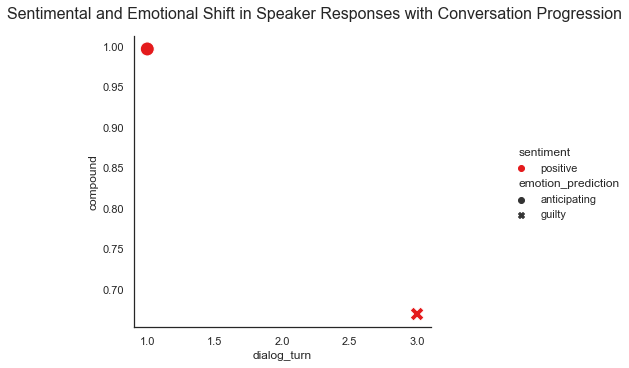

In [78]:
test_examples(conversation_id) 

## More examples

### High engagement, neutral satisfaction (but should be positive satisfaction)

In [61]:
df[df["conversation_id"] == 1732]

,conversation_id,subreddit,post_title,author,dialog_turn,text,compound,sentiment,emotion_prediction
4125,1732,MentalHealthSupport,"Hello, I need some advice/help",itsyaboi-apyr,1,"I’m kinda worried about posting this here because I don’t know if it is correct or not but I’m stuck in a very bad anxiety hole atm, I posted this in one of the legal advice subs and everyone said it’s more of a mental health problem, (also sorry I don’t know how to do paragraphs) ok so recently every single day and night I’ve been having panic attacks over something that happened 2-3 years ago, when I was 13 I was on pornhub and came across Ben 10 hentai and being thirty I was very stupid a...",-0.9960,negative,anticipating
4126,1732,MentalHealthSupport,"Hello, I need some advice/help",SophieSofar,2,No it's not illegal and you won't get in trouble for it. Especially as pornhub is legal. There's weirder things on there like scooby doo or American dad sketches. We all get curious. There's nothing to worry about x,0.8477,positive,faithful
4127,1732,MentalHealthSupport,"Hello, I need some advice/help",itsyaboi-apyr,3,"Thank you so much, I’ve felt so bad for so long, I was at the point where I can’t handle it anymore, I know this whole thing sounds stupid but I have been having serious suicidal thoughts over it, after reading your comment I’m crying lol, I was so worried about posting this but I’m at the point where it was either a suicidal help line or this, I chose this because I wasn’t brave enough for the latter but seriously thank you I was so nervous, also please excuse my lack of ability to do parag...",-0.9430,negative,anxious
4128,1732,MentalHealthSupport,"Hello, I need some advice/help",SophieSofar,4,No problem. I was the same when I started exploring that side of the web. It's harmless x,0.5037,positive,sentimental
4129,1732,MentalHealthSupport,"Hello, I need some advice/help",itsyaboi-apyr,5,So do you really think I’ll be ok?,0.0000,neutral,sentimental
4130,1732,MentalHealthSupport,"Hello, I need some advice/help",SophieSofar,6,Yeah for sure. Pornhub can't have anything illegal on there or they'll lose their licence,0.5753,positive,angry
4131,1732,MentalHealthSupport,"Hello, I need some advice/help",itsyaboi-apyr,7,"I was just really worried because i read that even hentai which is underage is illegal, so as you could probably guess I had a panic attack, but it’s been 2-3 years so I don’t think I’ll be in trouble right? And I never downloaded it",-0.8688,negative,embarrassed
4132,1732,MentalHealthSupport,"Hello, I need some advice/help",SophieSofar,8,Kids sent each other weirder stuff when I was in school. If nothing has happened by now it won't happen x,-0.1280,negative,embarrassed
4133,1732,MentalHealthSupport,"Hello, I need some advice/help",itsyaboi-apyr,9,"Thank you, your really nice which really helps my anxiety, I hope you have an amazing year, also would it be ok if I ever messaged you just in case I was worrying?",0.9189,positive,sentimental
4134,1732,MentalHealthSupport,"Hello, I need some advice/help",SophieSofar,10,No problem. Hopefully this advice will allow you to move forward with your life x,0.2263,positive,sentimental


Conversation length:  10
Speaker-listener turn difference:  None  -->  high engagement
Sentiment shift:  0.2  with grateful bonus:  0  -->  neutral satisfaction
Classification summary:  high engagement, neutral satisfaction



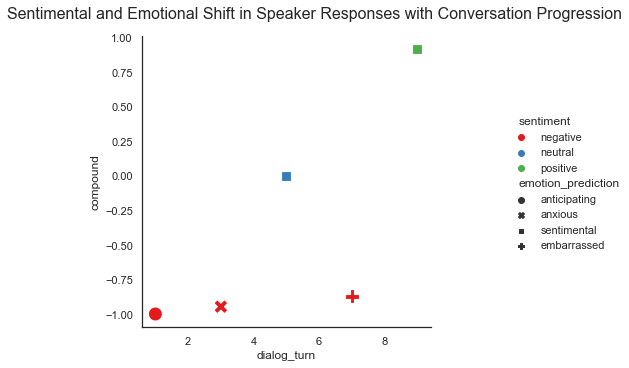

In [62]:
test_examples(1732) 

### High engagement, moderate satisfaction

In [63]:
df[df["conversation_id"] == 1003]

,conversation_id,subreddit,post_title,author,dialog_turn,text,compound,sentiment,emotion_prediction
2418,1003,MentalHealthSupport,Mood swings from random bits of information.,q-6u,1,"A bit of background information. I smoked weed twice in my life, first time in november of 2018 and second in april of 2019. both times i had extreme panic attacks that were amplified by my depersonalization disorder. I get really stressed out when I think about those episodes I had, and worry about death constantly. Recently, my girlfriend has admitted to me that she’s been smoking weed regularly for over a year. I don’t know why, but that bothered me and put me in a really depressed moo...",-0.9820,negative,grateful
2419,1003,MentalHealthSupport,Mood swings from random bits of information.,you_are_marvelous,2,"Well, I'm going to take a stab at it and say that you have mixed feelings and anxiety because you've been raised to think of weed as a bad thing and it's been demonized. So there's already a stigma there for you when it comes to the drug. Then there's the other side of it, which is you tried it, you had a severe panic attack (which can happen depending on the type of weed. I've had one as well with some kinds, and not with others. And I've had depersonalization on weed too. Your frame of min...",-0.8813,negative,anxious
2420,1003,MentalHealthSupport,Mood swings from random bits of information.,q-6u,3,"you hit the nail on the head with that egg analogy. except if i were you, i’d be under this false idea that eggs are killing everyone and turning them into shitty burnouts. i don’t know why.",-0.8402,negative,sentimental
2421,1003,MentalHealthSupport,Mood swings from random bits of information.,you_are_marvelous,4,Awww. I’m sorry you feel that way. I’d look into why you’re having that reaction to it. 💗,0.6808,positive,sentimental
2422,1003,MentalHealthSupport,Mood swings from random bits of information.,q-6u,5,i feel so alone in my life and it eats me up inside to hear that the one i love is having a normal reaction to it. i feel left out and angry at the same time and i just cut my wrists tonight to get my mind off of her. i’m a fucking wreck,-0.7192,negative,embarrassed
2423,1003,MentalHealthSupport,Mood swings from random bits of information.,you_are_marvelous,6,Did you self-harm or attempt suicide? Are you okay?!,-0.6430,negative,sentimental
2424,1003,MentalHealthSupport,Mood swings from random bits of information.,q-6u,7,self harm.,-0.5423,negative,surprised
2425,1003,MentalHealthSupport,Mood swings from random bits of information.,you_are_marvelous,8,How are you doing today?,0.0000,neutral,grateful
2426,1003,MentalHealthSupport,Mood swings from random bits of information.,q-6u,9,"i’ve been mych, much better since i last logged into reddit. thanks for sticking around, and for your help. seriously.",0.7783,positive,grateful
2427,1003,MentalHealthSupport,Mood swings from random bits of information.,you_are_marvelous,10,So glad to hear that! And you’re very welcome. :),0.8795,positive,anticipating


Conversation length:  10
Speaker-listener turn difference:  None  -->  high engagement
Sentiment shift:  0.59  with grateful bonus:  0.4  -->  moderate satisfaction
Classification summary:  high engagement, moderate satisfaction



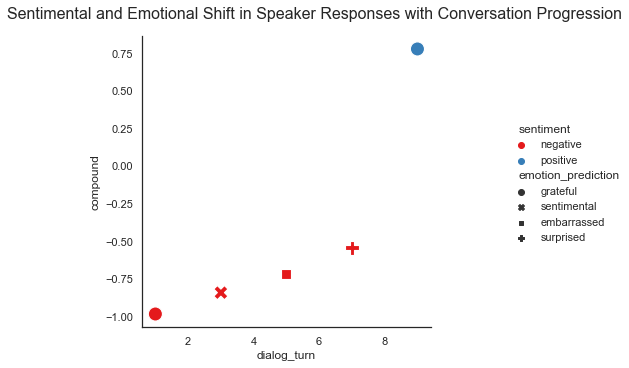

In [64]:
test_examples(1003) 

### High engagement, neutral satisfaction

In [65]:
df[df["conversation_id"] == 854]

,conversation_id,subreddit,post_title,author,dialog_turn,text,compound,sentiment,emotion_prediction
2028,854,MentalHealthSupport,"Whenever I'm alone I get really depressed, and I worry about my friends too much",EvieCryophoenix,1,"Ok so I haven't been diagnosed with anything fwi. But it's gotten to the point where if I'm alone or not busy I get really depressed about random stuff, and I can't help it, I always put happy music on to try and help but it doesn't. I've had the most amazing weekend ever from Friday to Monday I was at a friend's house and ive never laughed so much in such a short amount of time in my life. But now (Tuesday) I just feel awful, empty, sad. And idk why. And I have this real problem where I g...",0.9023,positive,anxious
2029,854,MentalHealthSupport,"Whenever I'm alone I get really depressed, and I worry about my friends too much",MorningStar113,2,"Maybe your extroverted, and something else is making those feelings worse. It might just be that you really need to be around people. Don't worry, you're going to be okay. I'm really sorry, I really wish I could help more",0.6492,positive,guilty
2030,854,MentalHealthSupport,"Whenever I'm alone I get really depressed, and I worry about my friends too much",EvieCryophoenix,3,I'm not though. I like being inside the house. And there is something that makes everything worse but that's personal.,-0.3828,negative,lonely
2031,854,MentalHealthSupport,"Whenever I'm alone I get really depressed, and I worry about my friends too much",MorningStar113,4,"I'm really sorry. I'm not an expert, and I really wish I could help you. The most I can do is give you someone to talk to",0.6249,positive,sentimental
2032,854,MentalHealthSupport,"Whenever I'm alone I get really depressed, and I worry about my friends too much",EvieCryophoenix,5,Does this sound like anything serious?,0.2960,positive,grateful
2033,854,MentalHealthSupport,"Whenever I'm alone I get really depressed, and I worry about my friends too much",MorningStar113,6,"From my very limited knowledge, it doesn't seem to be. It seems to be just something with your personality, not anything serious. But again, I'm not an expert. I'm sorry",-0.2348,negative,sentimental
2034,854,MentalHealthSupport,"Whenever I'm alone I get really depressed, and I worry about my friends too much",EvieCryophoenix,7,"its okay, thanks for the help",0.7579,positive,furious
2035,854,MentalHealthSupport,"Whenever I'm alone I get really depressed, and I worry about my friends too much",MorningStar113,8,"If you need someone to talk to, I'd like to volunteer",0.3612,positive,sentimental


Conversation length:  8
Speaker-listener turn difference:  None  -->  high engagement
Sentiment shift:  0.012  with grateful bonus:  0  -->  neutral satisfaction
Classification summary:  high engagement, neutral satisfaction



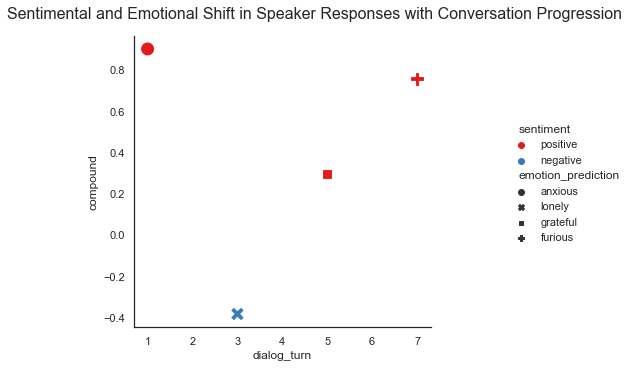

In [66]:
test_examples(854) 

### Moderate engagement, neutral satisfaction

This is also an example with merged speaker turns. 

In [67]:
df[df["conversation_id"] == 24]

,conversation_id,subreddit,post_title,author,dialog_turn,text,compound,sentiment,emotion_prediction
55,24,MentalHealthSupport,Threatened by a stranger about mental disability.,N08ody,1,"How they knew ill never know... But SOMEONE told them that shouldnt have... Here goes... I was on my way home after an evaluation ( dont worry everyone, still nutty) and i stop by the grocery store to pick up a few things. . and the cashier says, "" we pay for that, dont we?"" in relation to my purchase. How in the hell did a cashier know i was on disability? Giving me a reason, without an identifiable motive is a good way to get yourself hurt. Keep it up.",-0.8225,negative,anxious
56,24,MentalHealthSupport,Threatened by a stranger about mental disability.,shatterSquish,2,"That doesn't sound at all like they knew you were on disability. I think you're jumping to conclusions here. For example, their comment would also make sense in another context: if they just had to deal with a shoplifting kid and had just given a lecture about how everyone needs to pay for the stuff they want.",0.3400,positive,anxious
57,24,MentalHealthSupport,Threatened by a stranger about mental disability.,N08ody,3,"Hey squish. Thanks for not just telling me it was ""all in my head.""",0.4404,positive,sentimental
58,24,MentalHealthSupport,Threatened by a stranger about mental disability.,N08ody,4,"A. I wasnt shoplifting. And B. The phrase ""We pay for that, dont we?"" is not a normal phrase. Appreciate your input, but i disagree.",-0.4118,negative,guilty


Conversation length:  4
Speaker-listener turn difference:  1  -->  moderate engagement
Sentiment shift:  0.63  with grateful bonus:  0  -->  moderate satisfaction
Classification summary:  moderate engagement, moderate satisfaction



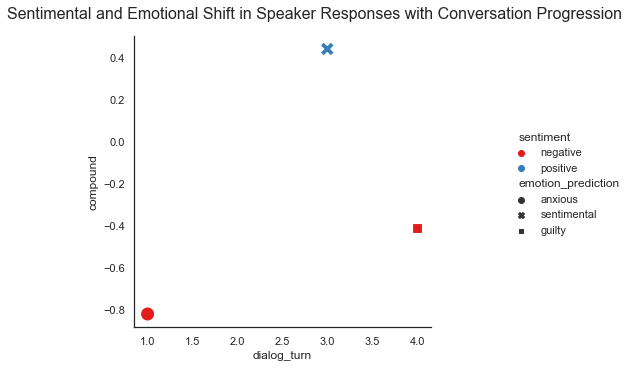

In [68]:
test_examples(24) 

### Low engagement, moderate satisfaction

In [69]:
df[df["conversation_id"] == 35]

,conversation_id,subreddit,post_title,author,dialog_turn,text,compound,sentiment,emotion_prediction
80,35,MentalHealthSupport,Losing hope,kelseybrynn,1,I'm not doing well today. I don't know how to contain or control my angst and abandonment issues.,-0.6386,negative,lonely
81,35,MentalHealthSupport,Losing hope,Leena52,2,"If it is interfering with your ability to work and function, then you may wish to seek out professional help. This sub is a good resource; however, you are worthy of more. If you can not get to a professional or find some one to interact with in person, you may need to spend some time focused on something that you enjoy, preferable outdoor time (sunlight is known to lift mood) or exercise (this is proven to help lift the mood by releasing the good brain chemicals). Staying focused on ones...",0.9837,positive,anticipating
82,35,MentalHealthSupport,Losing hope,kelseybrynn,3,Thank you...,0.3612,positive,sentimental


Conversation length:  3
Speaker-listener turn difference:  1  -->  low engagement
Sentiment shift:  0.5  with grateful bonus:  0  -->  moderate satisfaction
Classification summary:  low engagement, moderate satisfaction



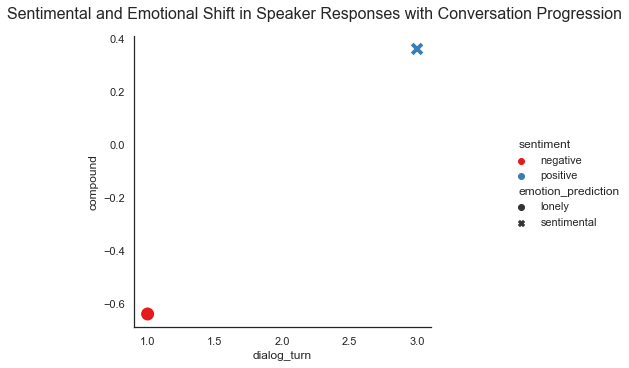

In [70]:
test_examples(35) 

## TODO: Create compound scores for engagement and satisfaction 

Check out VADER and Chun-Hung's code

**VADER:**

The **compound score** is computed by summing the **valence** scores of each word in the lexicon, adjusted according to the rules, and then **normalized** to be between -1 (most extreme negative) and +1 (most extreme positive). This is the most useful metric if you want a single unidimensional measure of sentiment for a given sentence. Calling it a 'normalized, weighted composite score' is accurate. 

It is also useful for researchers who would like to set standardized thresholds for classifying sentences as either positive, neutral, or negative. Typical **threshold values** (used in the literature cited on this page) are:
- **positive sentiment: compound score >= 0.05**
- **neutral sentiment: (compound score > -0.05) and (compound score < 0.05)**
- **negative sentiment: compound score <= -0.05**

**Satisfaction:**
- Take off points if speaker got offended from listener's response 
- Find a lexicon of gratitude tokens

**Engagement:**
- make scoring numerical (a compound score column)
    - put a weight to all the factors 
        - experiment and inspect which weights and threshold yield a good scoring

**Examples:**
- A few examples showing low/moderate/high engagement/satisfaction